In [1]:
import sys
sys.path.append("..")

from core import coeffs, intersection_points, compute_bounds, draw_oblate

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    
    """

    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    elif (mu == 1) and (l % 2 != 0):
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    else:
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
    return G

In [3]:
def g(x, y, z=None, n=0):
    """
    Return the nth term of the Green's basis (a scalar).
    
    """
    if z is None:
        z = np.sqrt(1 - x ** 2 - y ** 2)
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (nu % 2 == 0):
        I = [mu // 2]
        J = [nu // 2]
        K = [0]
        C = [(mu + 2) // 2]
    elif (l == 1) and (m == 0):
        I = [0]
        J = [0]
        K = [1]
        C = [1]
    elif (mu == 1) and (l % 2 == 0):
        I = [l - 2]
        J = [1]
        K = [1]
        C = [3]
    elif (mu == 1):
        I = [l - 3, l - 1, l - 3]
        J = [0, 0, 2]
        K = [1, 1, 1]
        C = [-1, 1, 4]
    else:
        I = [(mu - 5) // 2, (mu - 5) // 2, (mu - 1) // 2]
        J = [(nu - 1) // 2, (nu + 3) // 2, (nu - 1) // 2]
        K = [1, 1, 1]
        C = [(mu - 3) // 2, -(mu - 3) // 2, -(mu + 3) // 2]
    res = 0
    for i, j, k, c in zip(I, J, K, C):
        res += c * x ** i * y ** j * z ** k
    return res

def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""
    Gxy = G(n)
        
    func = lambda theta: Gxy[0](x(theta), y(theta)) * dx(theta) + Gxy[1](
        x(theta), y(theta)
    ) * dy(theta)
    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def qT_numerical(xi, n=0):
    """Compute the tT integral numerically from its integral definition."""
    res = 0
    for xi1, xi2 in xi.reshape(-1, 2):
        x = lambda xi: np.cos(xi)
        y = lambda xi: np.sin(xi)
           
        dx = lambda xi: -np.sin(xi)
        dy = lambda xi: np.cos(xi)
        res += primitive(x, y, dx, dy, xi1, xi2, n)
    return res

def pT(phi, b, xo, yo, ro, n=0):
    """Compute the pT integral numerically from its integral definition."""
    res = 0
    for phi1, phi2 in phi.reshape(-1, 2):
        x = lambda phi: ro * np.cos(phi) + xo
        y = lambda phi: ro * b * np.sin(phi) + yo
        
        dx = lambda phi: -ro * np.sin(phi)
        dy = lambda phi: b * ro * np.cos(phi)
        res += primitive(x, y, dx, dy, phi1, phi2, n)
    return res

def sT(phi, xi, b, xo, yo, ro, n=0):
    """The solution vector for occultations, computed via Green's theorem."""
    return pT(phi, b, xo, yo, ro, n) + qT_numerical(xi, n)

def sT_bruteforce(b, xo, yo, ro, n=0, res=300):

    # Create a fine grid
    pts = np.linspace(-1, 1, res)
    x, y = np.meshgrid(pts, pts)

    # Check if a point is inside the ellipse of the star
    in_star = (x ** 2) + (y ** 2) <= 1

    # Check if a point is under the occultor
    under_occultor = (x-xo) ** 2 + ((y - yo)/b) ** 2 <= ro ** 2

    
    # Now, compute the nth term in the basis...
    term = g(x, y, n=n)
    
    # And sum it over the integration region
    # Each pixel has area dA = (area of square) / (number of pixels)
    dA = 4 / (x.shape[0] * x.shape[1])
    integral = np.sum(term[in_star & under_occultor] * dA)
    
    return x, y, term, under_occultor, in_star, integral

<Axes: >

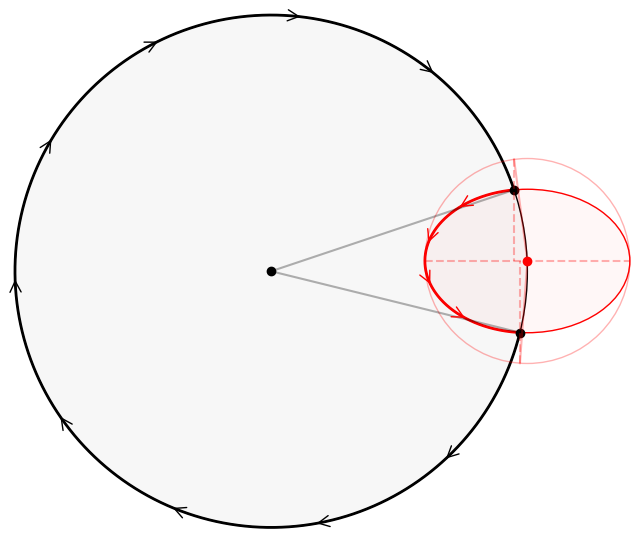

In [4]:
draw_oblate(0.7,1.0,0.04,0.4)

In [5]:
xi, phi = compute_bounds(0.7,1.0,0.04,0.4)

from tqdm.notebook import tqdm
numerical_circ = np.zeros(16)
for n in tqdm(range(16)):
    x, y, term, under_occultor, in_star, numerical_circ[n] = sT_bruteforce(0.7,1.0,0.04,0.4, n=n, res=1000)

  0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/_t/bqm0d4gd4gb4w_d2p9j445h00000gq/T/ipykernel_77385/3577801509.py:7: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - x ** 2 - y ** 2)


In [6]:
semi_analytic = np.zeros(16)
for n in tqdm(range(16)):
    semi_analytic[n] = sT(phi, xi,0.7,1.0,0.04,0.4, n=n)

  0%|          | 0/16 [00:00<?, ?it/s]

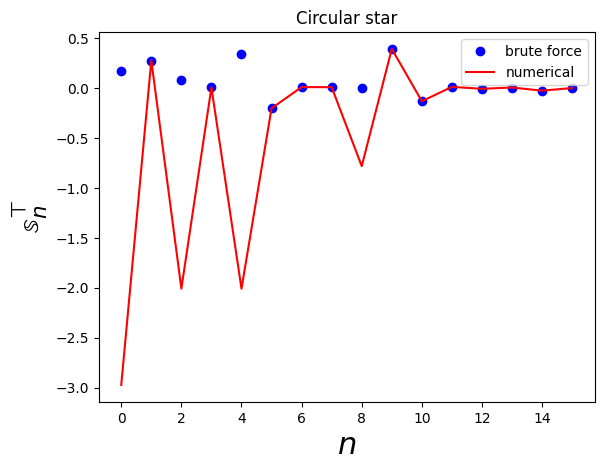

In [7]:
plt.plot(numerical_circ,'bo', label="brute force")
plt.plot(semi_analytic,'r-',label='numerical')

plt.legend()

plt.title("Circular star")
plt.xlabel(r"$n$", fontsize=22)
plt.ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);